In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import keras 

df = pd.read_pickle('dataset/train_dataset.pkl')
df['Normal/Attack'] = df['Normal/Attack'].apply(lambda x: 0 if x == 'Normal' else 1)

pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None) #50 for truncated view, -1 for full view

In [2]:

def get_train_test_dataset(df):
    split_date = '2015-12-28 10:29:13'
    data_train = df.loc[df['Timestamp'] <= split_date].copy()
    data_test = df.loc[df['Timestamp'] > split_date].copy()

    return data_train, data_test

In [3]:
train, test = get_train_test_dataset(df)
test = test.reset_index(drop=True)

train['Normal/Attack'].replace(['Normal', 'Attack'], [0, 1], inplace=True)
test['Normal/Attack'].replace(['Normal', 'Attack'], [0, 1], inplace=True)


In [4]:
cols_numeric = list(df.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('index')
cols_numeric.remove('attack')

# for col in cols_continuous_tank:
#     cols_numeric.remove(col)

cols_discrete = []
cols_continuous = []

for col in cols_numeric:
    
    if len(df[col].unique()) <= 5:
        cols_discrete.append(col)
    else:
        cols_continuous.append(col)

Get the slope

In [14]:
def diff_num(a, n):
    for i in range(n, len(a)):
        if i == 0:
            yield 0
        else:
            yield a[i] - a[i-n]

In [6]:
from numpy import diff
n = 1

for col in cols_continuous:
    df[f'{col}_discrete'] = list(np.zeros(n)) + [x for x in diff(df[col], n=n)] #1 if x > 0 else -1

In [15]:
attack_df = pd.read_csv('attacks_df.csv')
attack_df['start_time'] = pd.to_datetime(attack_df['start_time'])
attack_df['end_time'] = pd.to_datetime(attack_df['end_time'])

def get_timestamp_attack(index_attack, offset):
    index_start = df[df['Timestamp'] == attack_df.iloc[index_attack]['start_time']].index[0] - offset
    index_end = df[df['Timestamp'] == attack_df.iloc[index_attack]['end_time']].index[0] + offset
    return index_start, index_end

In [16]:

def get_index_attack(attack_name):
    list_attack_index = []
    for i, attack in zip(attack_df['num_attack'], attack_df['attack']):
        attack = attack.replace('-', '')
        if attack_name in attack:
            list_attack_index.append(i)
    return list_attack_index

# FTT

In [7]:
def fft_denoiser(x, n_components, to_real=True):
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

In [17]:

normalization = StandardScaler()
df_normalized = normalization.fit_transform(df[cols_numeric])
df_normalized = pd.DataFrame(df_normalized, columns=cols_numeric)
df_normalized['Timestamp'] = df['Timestamp']


train_normalized, test_normalized = get_train_test_dataset(df_normalized)

In [18]:
feature = 'LIT301'

In [57]:

n = 100

for col in cols_continuous:
    median_ = pd.DataFrame(columns=['x', 'y'])
    for i in range(0, len(df_normalized), n):
        med = np.median(df_normalized.iloc[i:i+n][col])
        a = n
        if i+n > len(df_normalized):
            a = len(df_normalized) - i
        median_ = pd.concat(objs=[median_, pd.DataFrame({'x': [i for i in range(i, i+a)], 'y': [med for i in range(i, i+a)]})], axis=0)
    df[f'{col}_median'] = median_['y'].reset_index(drop=True)
    
# ~38 mins

In [58]:
df.to_pickle('dataset/train_dataset_median.pkl')

## Test the slope on the median

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(pd.DataFrame(median_['y_discrete'].reset_index(drop=True)).iloc[0:100000])
plt.show()

In [20]:

n = 100
denoiser = []
for i in range(0, len(df_normalized), n):
    x = fft_denoiser(df_normalized.iloc[i:i+n][feature], 20)
    denoiser = np.append(denoiser, x)

In [21]:

x_slope_denoiser = [0] * 1 + [ x for x in diff_num(np.array(median_['y']), 1)]#1 if x > 0 else -1 for

slope_denoiser = pd.DataFrame(x_slope_denoiser, columns=['slope_denoiser'])
slope = slope_denoiser['slope_denoiser'].apply(lambda x: np.abs(x) if x != 0 else 0)

In [22]:
all_median = [slope[x] for x in range(0, len(slope), 100) if slope[x] > 0]
median_de = np.quantile(all_median, 0.95)

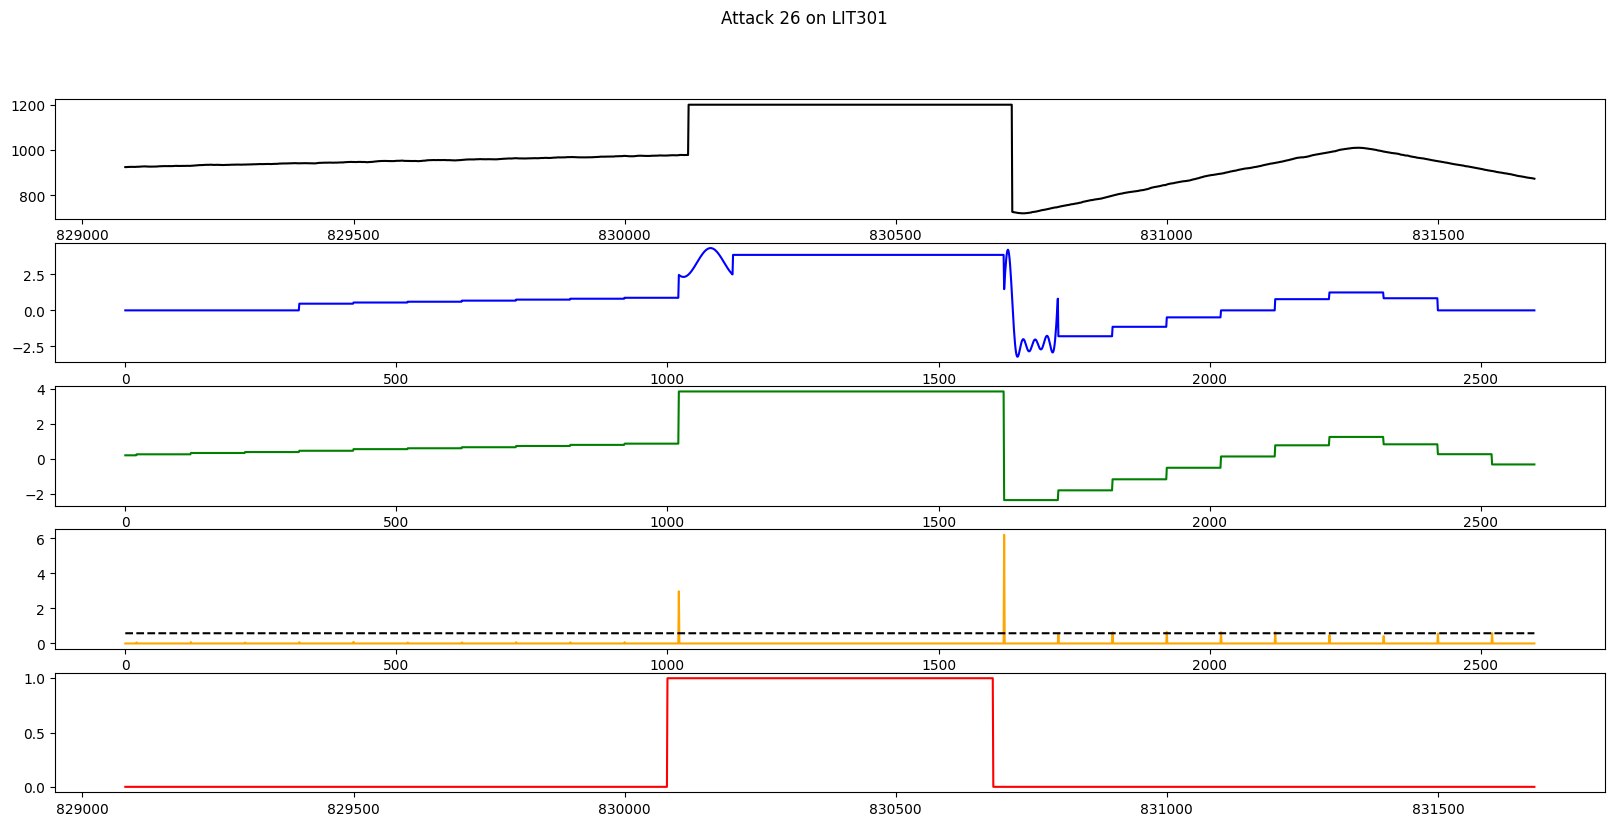

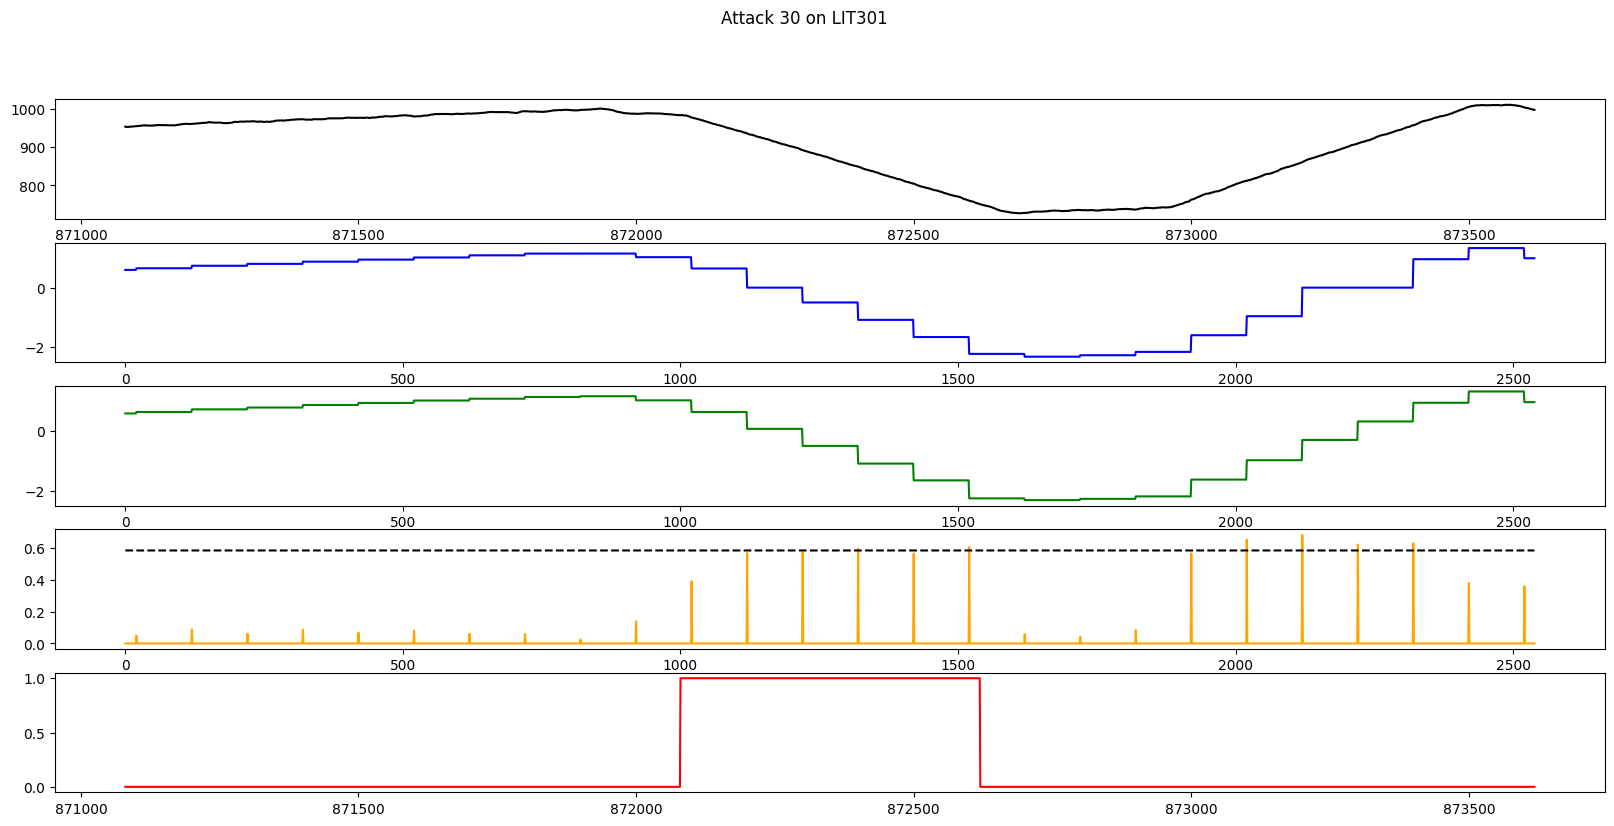

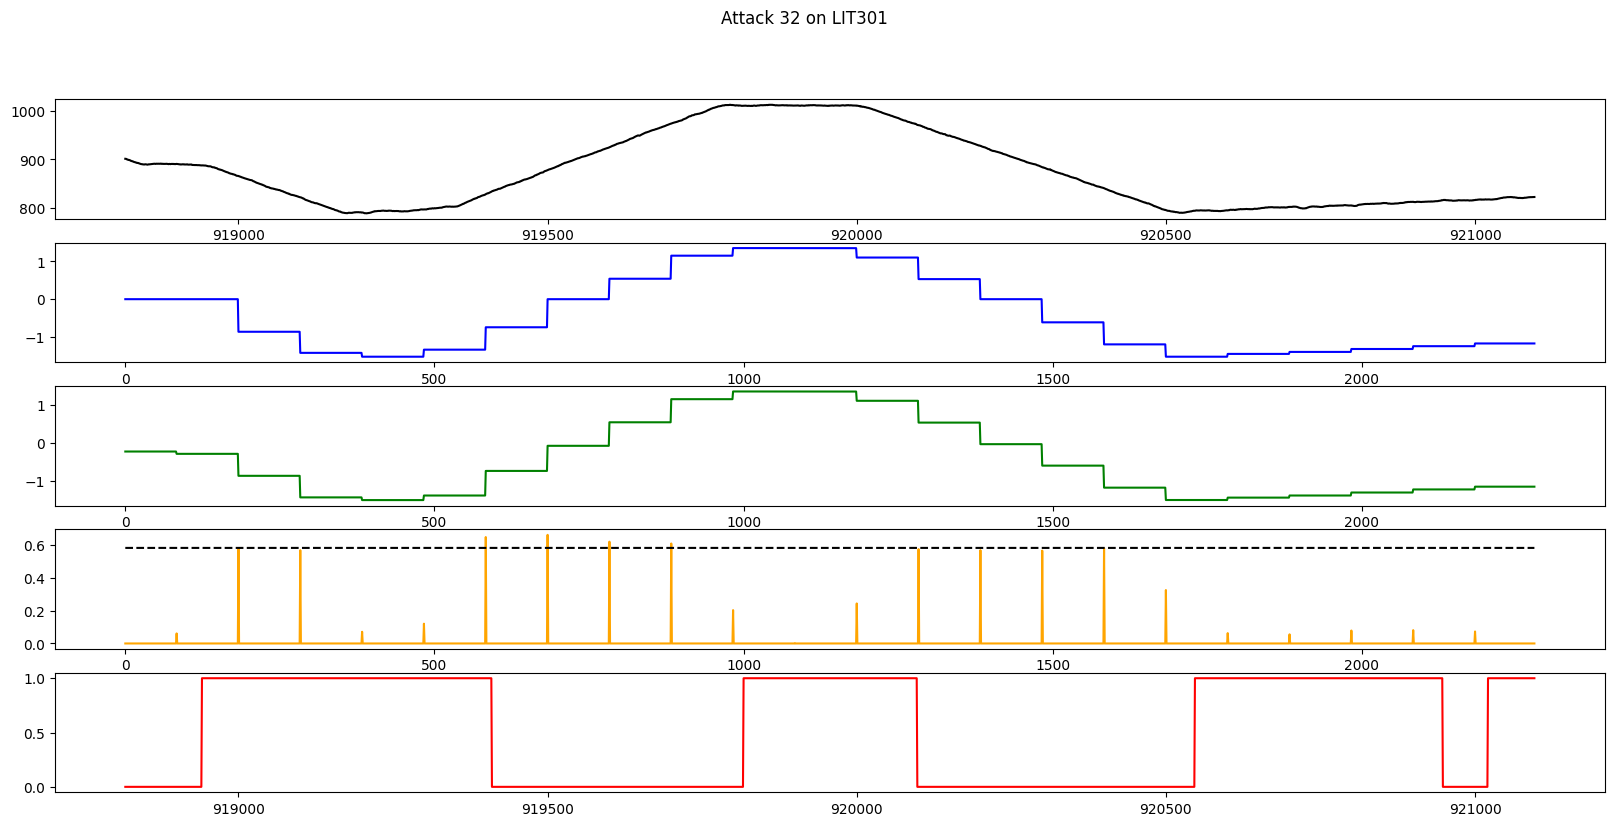

In [26]:
for attack in get_index_attack('LIT301'):
    
    fig, ax = plt.subplots(5, 1, figsize=(20, 9))

    index_min, index_max = get_timestamp_attack(index_attack=attack, offset=1000)

    ax[0].plot(df[feature][index_min:index_max], color='black')
    ax[1].plot(np.array(denoiser)[index_min:index_max], color='blue')
    ax[2].plot(np.array(median_['y'])[index_min:index_max], color='green')
    ax[3].plot(slope[index_min:index_max].reset_index(drop=True), color='orange')
    ax[3].plot([median_de for i in range(index_max-index_min)], color='black', linestyle='--')
    ax[4].plot(df['Normal/Attack'][index_min:index_max], color='red')
    fig.suptitle(f'Attack {attack} on {feature}')
    plt.show()

/home/guillaume/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/guillaume/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NameError: name 'fft_denoise' is not defined

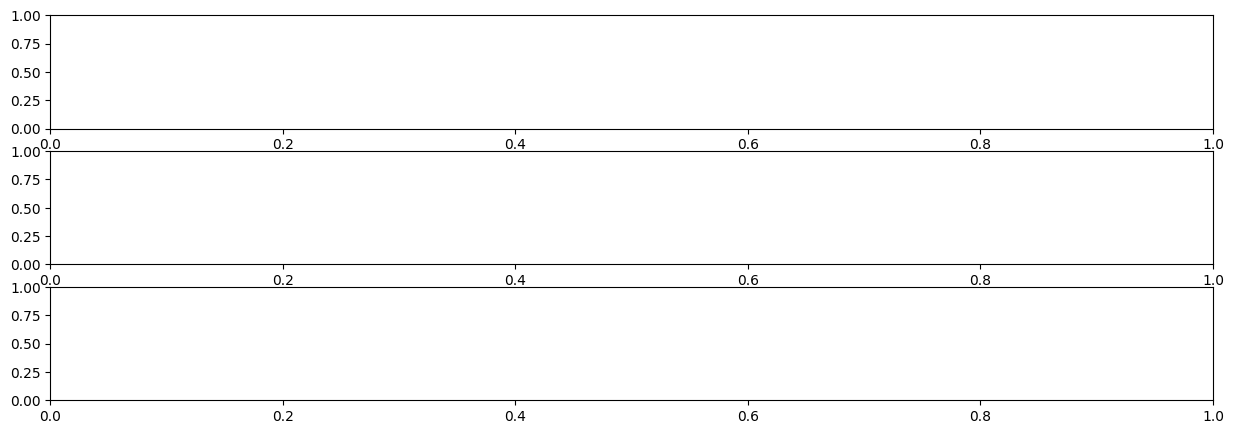

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(15, 5))

index_min = 0
index_max = 25000

median_de = np.median(denoiser) 
ax[0].plot(pd.DataFrame(fft_denoise).iloc[index_min:index_max], color = 'red')
ax[0].plot(pd.DataFrame(data).iloc[index_min:index_max]-1, color='black')


median_['slope'] = median_[['denoiser', 'y']].apply(lambda x: 1 if x[0] > x[1] else -1, axis=1)

# x_slope_denoiser = [0] * 1 + [1 if x > median_de else -1 for x in np.array(median_['denoiser'])]
x_slope_denoiser = [0] * 1 + [ x for x in diff_num(np.array(median_['denoiser']), 1)]#1 if x > 0 else -1 for

# x_slope_fft_denoise = [0] * 1 + [1 if x > 0 else -1 for x in diff_num(fft_denoise, 1)]
# x_slope_data = [0] * 1 + [1 if x > 0 else -1 for x in diff_num(data, 1)]



ax[0].plot(pd.DataFrame(denoiser).iloc[index_min:index_max].reset_index(drop=True), color='blue')
ax[0].plot(df_normalized.iloc[index_min:index_max][feature].reset_index(drop=True), color='green')
ax[0].axhline(y=median_de , color='black', linestyle='--')

ax[1].plot(np.array(median_['y'].iloc[index_min:index_max].reset_index(drop=True)), color='green')
# ax[1].plot(np.array(median_['slope'].iloc[index_min:index_max].reset_index(drop=True)), color='green')


ax[2].plot(x_slope_denoiser[index_min:index_max], color='black')

ax[2].plot(np.array(median_['slope'].iloc[index_min:index_max].reset_index(drop=True) )-2.2, color='blue')
# ax[1].plot(x_slope_fft_denoise[index_min:index_max], color='red')
# ax[1].plot(pd.DataFrame(x_slope_data).iloc[index_min:index_max]-2.2, color='black')
plt.show()

## Isolation Forest

In [60]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as score


In [62]:
# df_backup = df.copy()

In [63]:
df = pd.read_pickle('dataset/train_dataset_median.pkl')

In [65]:
cols_numeric = list(df.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('index')
cols_numeric.remove('attack')

cols_discrete = []
cols_continuous = []

for col in cols_numeric:
    
    if len(df[col].unique()) <= 5:
        cols_discrete.append(col)
    else:
        cols_continuous.append(col)


In [68]:
train, test = get_train_test_dataset(df)

In [69]:
y_test = test['Normal/Attack']

In [70]:
def measure_performance(model, X_test, y_true, map_labels):
    
    df_pred_test = X_test.copy()
    df_pred_test['Normal/Attack'] = model.predict(X_test)
    if map_labels:
        df_pred_test['Normal/Attack'] = df_pred_test['Normal/Attack'].map({1: 0, -1: 1})
    x_pred = df_pred_test['Normal/Attack'] 
    matrix = confusion_matrix(x_pred, y_true)

    sns.heatmap(pd.DataFrame(matrix, columns = ['Actual', 'Predicted']),
                xticklabels=['Normal [0]', 'Attack [1]'], 
                yticklabels=['Normal [0]', 'Attack [1]'], 
                annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    
    print(classification_report(x_pred, y_true))
    
    model_score = score(x_pred, y_true,average='macro')
    print(f'f1_score: {np.round(model_score[2]*100, 2)}%')
    
    return model_score

In [75]:
discrete_cols = []
for col in df.columns:
    if 'median' in col or col in cols_discrete:
        discrete_cols.append(col)

discrete_cols.remove('Normal/Attack')

In [77]:
train_feature = train[discrete_cols]
test_feature = test[discrete_cols]

In [94]:

def get_discrete_median(df, col):
    df_copy = df[col].copy()
    df_copy = pd.DataFrame(df_copy, columns=[col])
    median_train, median_test = get_train_test_dataset(df[[col, 'Timestamp']].copy())
    
    median_ = median_train[col].copy()
    
    median_ = pd.DataFrame(median_, columns=[col])

    slope_feature = [0] * 1 + [ x for x in diff_num(np.array(median_[col]), 1)]#1 if x > 0 else -1 for

    slope_x = pd.DataFrame(slope_feature, columns=['slope'])

    slope = slope_x['slope'].apply(lambda x: x if x != 0 else 0)

    median = [slope[x] for x in range(0, len(slope), 100) if slope[x] != 0]

    median_threshold = np.quantile(median, 0.95)

    df_copy['y_discrete'] = df_copy[col].apply(lambda x: 1 if x > median_threshold else 0)

    return df_copy['y_discrete']

In [85]:
median_cols = [col for col in train_feature.columns if 'median' in col]

In [95]:
for col in median_cols:
    df[f'{col}_slope'] = get_discrete_median(df, col)

In [96]:
slope_cols = [col for col in df.columns if 'slope' in col]

In [99]:
discrete_cols = []
for col in df.columns:
    if 'slope' in col or col in cols_discrete:
        discrete_cols.append(col)

discrete_cols.remove('Normal/Attack')

In [101]:
train, test = get_train_test_dataset(df)

In [102]:
train_feature = train[discrete_cols]
test_feature = test[discrete_cols]

In [104]:
model_isf = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.001, max_features=train_feature.shape[1])
model_isf.fit(train_feature)

/Users/david/SWaT_Analysis_TFE/.env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.001, max_features=45)

Isolation Forest (baseline) model
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    410855
           1       0.60      0.87      0.71     37310

    accuracy                           0.94    448165
   macro avg       0.79      0.91      0.84    448165
weighted avg       0.96      0.94      0.95    448165

f1_score: 83.86%


/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_82044/1092890683.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_df = pd.DataFrame().append({'model_name':model_name,


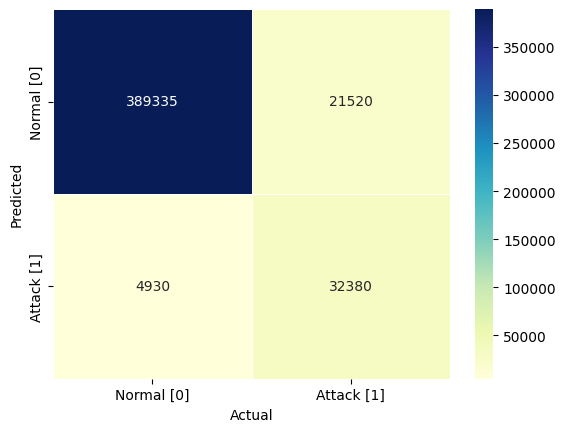

In [84]:

model_name = 'Isolation Forest (baseline)'
print(f'{model_name} model')

map_labels = True
model_score = measure_performance(model_isf, test_feature, y_test, map_labels)

performance_df = pd.DataFrame().append({'model_name':model_name, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)

n_estimators:100, c:0.1   = 44757 attacks   175000 normal 45 features
n_estimators:100, c:0.01  = 35153 attacks   19473  normal 45 features
n_estimators:100, c:0.001 = 33958 attacks   3476   normal 45 features

n_estimators:500, c:0.0000001 = 18000 attacks 289 normal 45 features
n_estimators:500, c:0.001 = 32387  attacks 4638 normal 45 features

n_estimators:300, c:0.1   = 42721 attacks 126000 normal


n_estimators:100, c:0.1   = 44757 attacks 175000 normal 45 features
n_estimators:100, c:0.1   = 43458 attacks 181000 normal 37 features

### Get State

In [106]:
discrete_cols = []
for col in df.columns:
    if 'slope' in col or col in cols_discrete:
        discrete_cols.append(col)

discrete_cols.remove('Normal/Attack')

In [138]:
df_state = df[discrete_cols]

In [139]:
df_state['Normal/Attack'] = df['Normal/Attack']
df_state['Timestamp'] = df['Timestamp']

/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_82044/985057770.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_state['Normal/Attack'] = df['Normal/Attack']
/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_82044/985057770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_state['Timestamp'] = df['Timestamp']


In [110]:
def set_sequence(row):
    sequence = str('')
    for value in row:
        sequence += str(value)
    return sequence

In [157]:
df_state['state'] = df_state[discrete_cols].apply(lambda row: set_sequence(row), axis=1)

/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_82044/1378822982.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_state['state'] = df_state[discrete_cols].apply(lambda row: set_sequence(row), axis=1)


In [158]:
df_state_train, df_state_test = get_train_test_dataset(df_state)

In [159]:
print('df_state_train states: ', len(df_state_train['state'].value_counts()))
print('df_state_test states: ', len(df_state_test['state'].value_counts()))
print('total df_state states: ', len(df_state['state'].value_counts()))
print('df_state state in common', (len(df_state_train['state'].value_counts())+len(df_state_test['state'].value_counts()))-len(df_state['state'].value_counts()))
print('percentage of common:', ((len(df_state_train['state'].value_counts())+len(df_state_test['state'].value_counts()))-len(df_state['state'].value_counts())) / len(df_state['state'].value_counts()))

df_state_train states:  1719
df_state_test states:  2379
total df_state states:  3860
df_state state in common 238
percentage of common: 0.061658031088082904


In [160]:
count_states = pd.DataFrame(columns=['state', 'time'])
list_of_states = []

for i in range(len(df_state_test)):
    if df_state_test['state'].iloc[i] not in list_of_states:
        count_states = pd.concat(objs=[count_states, pd.DataFrame({'state': df_state_test['state'].iloc[i], 'time': [df_state_test['Timestamp'].iloc[i]]})], axis=0)
        list_of_states.append(df_state_test['state'].iloc[i])

count_states = count_states.reset_index(drop=True)
count_states['count_state'] = count_states.index

In [161]:
df_count_states = pd.merge(df_state_test, count_states, on='state', how='right')

<AxesSubplot:xlabel='time', ylabel='count_state'>

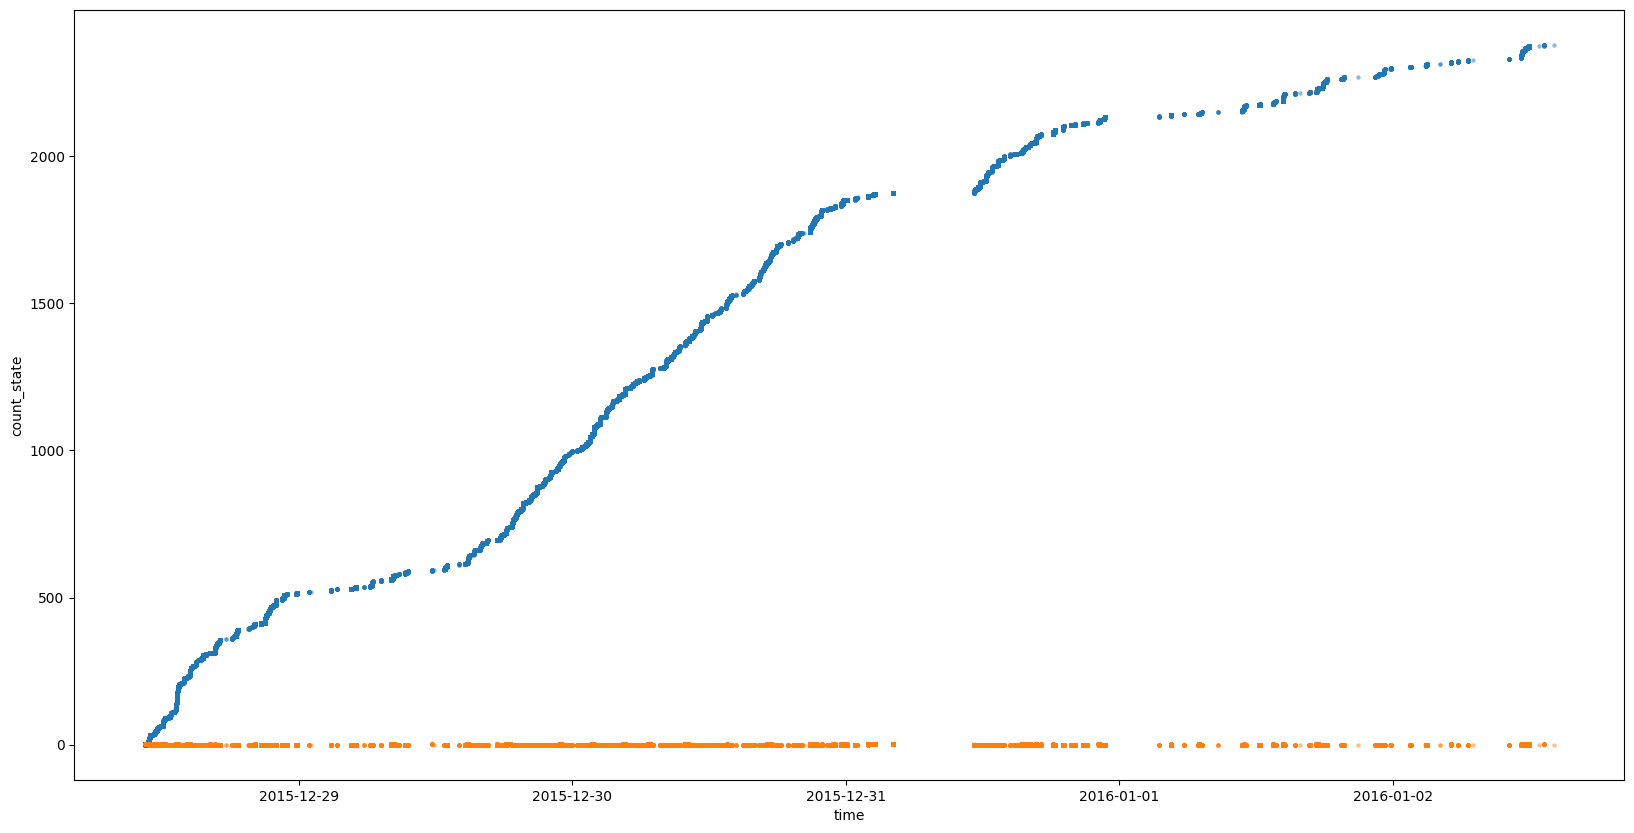

In [162]:
# count_states.plot(x='time', y='index', kind='scatter')
ax, fig = plt.subplots(figsize=(20, 10))
sns.scatterplot(x='time', y='count_state', data=df_count_states.reset_index(drop=True), s=10, alpha=0.5, marker='o', linewidth=0)
sns.scatterplot(x='time', y='Normal/Attack', data=df_count_states.reset_index(drop=True), s=10, alpha=0.5, marker='o', linewidth=0)


<AxesSubplot:xlabel='time', ylabel='count_state'>

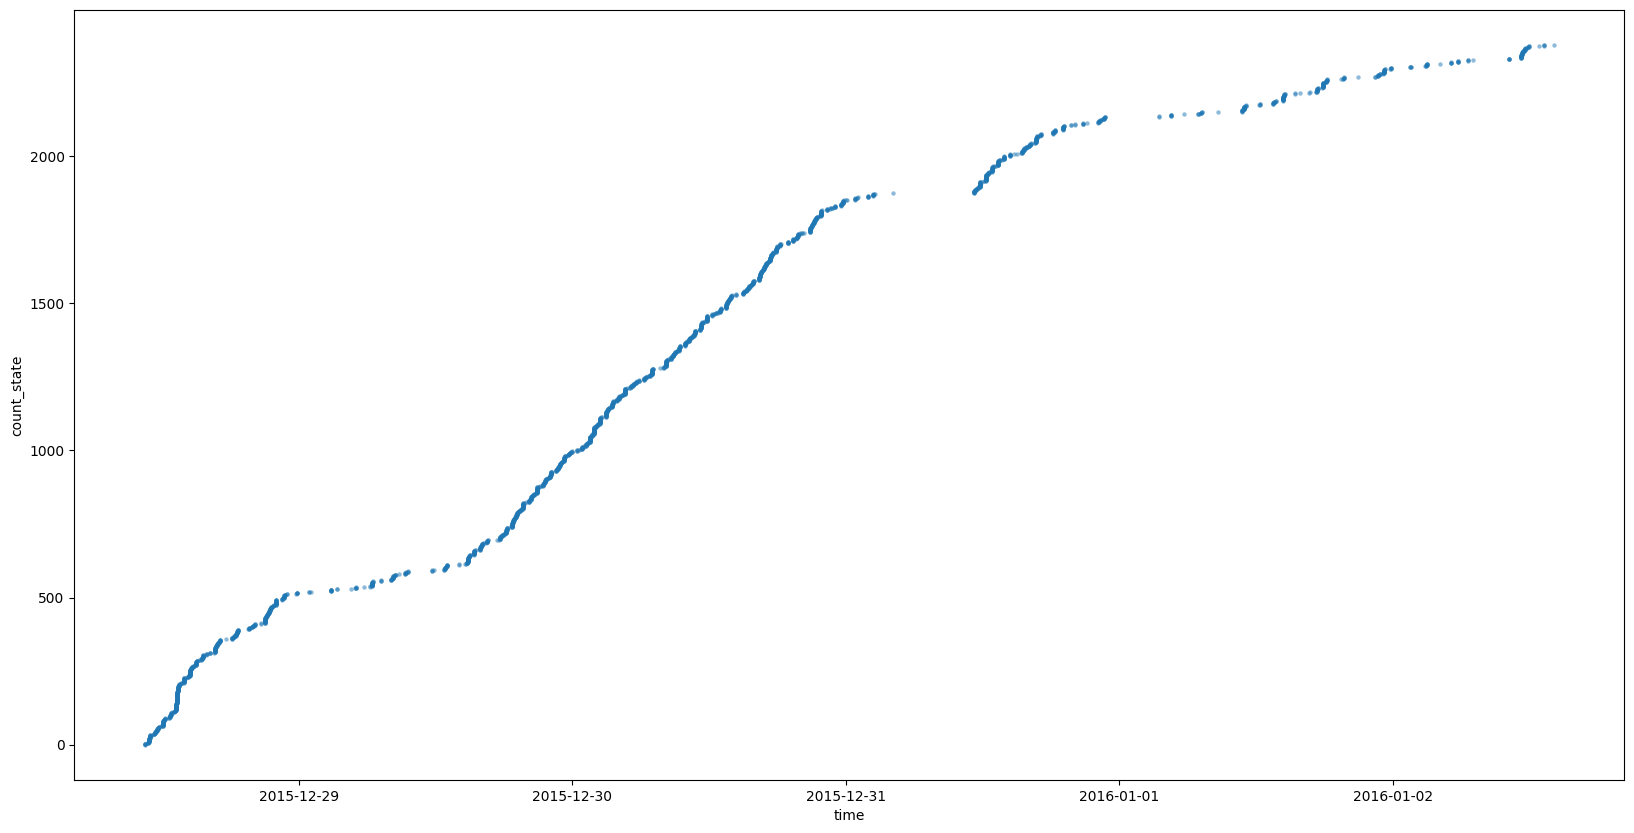

In [163]:
# count_states.plot(x='time', y='index', kind='scatter')
ax, fig = plt.subplots(figsize=(20, 10))
sns.scatterplot(x='time', y='count_state', data=count_states, s=10, alpha=0.5, marker='o', linewidth=0)


In [164]:
known_state_attack = df_state[df_state['Normal/Attack'] == 1]['state'].unique()
len(known_state_attack)

422

In [165]:
df_state['Normal/Attack'].value_counts()

0    878419
1     53900
Name: Normal/Attack, dtype: int64

In [166]:
attack_state = pd.DataFrame(columns=['state', 'cnt_attack', 'cnt_normal'])

for state in known_state_attack:
    state_cnt = df_state[df_state['state'] == state]
    df_state_runner = pd.DataFrame({
        'state': [state], 
        'cnt_attack': len(state_cnt[state_cnt['Normal/Attack'] == 1]),
        'cnt_normal': len(state_cnt[state_cnt['Normal/Attack'] == 0])
    })
    attack_state = pd.concat(objs=[attack_state, df_state_runner], axis=0)
    

In [168]:
attack_state.sort_values(by='cnt_attack', ascending=False)

,state,cnt_attack,cnt_normal
0,111111111111211111111010110001100011100000000,25727,0
0,111111111111211111111010100001100011100000000,5600,0
0,221212121121112212210100101001011001111111010,2409,18418
0,111111111111211212211010100001010000111111010,1456,0
0,221212121121112212210111001001010100011111110,760,0
...,...,...,...
0,221212121112212212211101001101010101011111110,1,0
0,211211111121212212210100100001010001111111010,1,0
0,211111111101212212211110100001010000111111010,1,13
0,211212121111111212211101100001011100011111110,1,0


In [170]:
known_state = df_state['state'].unique()
len(known_state)

3860

In [171]:
not_attack_state = pd.DataFrame(columns=['state', 'cnt_attack', 'cnt_normal'])

for state in known_state:
    state_cnt = df_state[df_state['state'] == state]
    df_state_runner = pd.DataFrame({
        'state': [state], 
        'cnt_attack': len(state_cnt[state_cnt['Normal/Attack'] == 1]),
        'cnt_normal': len(state_cnt[state_cnt['Normal/Attack'] == 0])
    })
    not_attack_state = pd.concat(objs=[not_attack_state, df_state_runner], axis=0)
    

In [173]:
not_attack_state.sort_values(by='cnt_normal', ascending=False)

,state,cnt_attack,cnt_normal
0,221212121121112212211101001001011101011111010,0,36212
0,221212121121112212210101001001011101011111010,0,35101
0,221212121121112212211100101001011001111111010,0,27070
0,221212121121112212210101001001011100011111010,0,19104
0,221212121121112212210100101001011001111111010,2409,18418
...,...,...,...
0,211111111010111212211111000101010101111111110,7,0
0,211111111110111212211111000101010101111111110,1,0
0,211111111111111212211111000101010101111111110,1,0
0,211111111101111212211111000101010101111111110,6,0


In [188]:
not_attack_state['ratio'] = not_attack_state[['cnt_attack', 'cnt_normal']].apply(lambda row: row[0] / np.abs(row[1]), axis=1)

/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_82044/3763029698.py:1: RuntimeWarning: divide by zero encountered in long_scalars
  not_attack_state['ratio'] = not_attack_state[['cnt_attack', 'cnt_normal']].apply(lambda row: row[0] / np.abs(row[1]), axis=1)


In [190]:
not_attack_state['ratio'] = not_attack_state['ratio'].apply(lambda x: 0 if x == np.inf else x)

In [194]:
not_attack_state[not_attack_state['cnt_attack'] != 0].sort_values(by='ratio', ascending=True).head(60)

,state,cnt_attack,cnt_normal,ratio
0,121212121121112211110011011001100100100000000,200,0,0.0
0,221211111121111212211100101001011001111111110,2,0,0.0
0,221211111121112212211100101001011001111111110,13,0,0.0
0,221211212121112212211100101001011001111111110,55,0,0.0
0,221211221121112212211100101001011001111111110,1,0,0.0
0,211111111210111212221110100001010001111111010,1,0,0.0
0,211111111210111212211110100001010001111111010,1,0,0.0
0,211111111010111212211110100001010001111111010,6,0,0.0
0,221211111101111212211100101001011001111111110,8,0,0.0
0,211111111110111212211110100001010001111111010,1,0,0.0


In [195]:
know_state = df_state_train['state'].unique()
attack_state = df_state_test['state'].unique()
common_state = np.intersect1d(know_state, attack_state)
not_common_state = np.setdiff1d(attack_state, know_state)

In [199]:
count = 0
count_normal = 0
for state in common_state:
    count += len(df_state_test[(df_state_test['state'] == state) & (df_state_test['Normal/Attack'] == 1)])
    count_normal += len(df_state_test[(df_state_test['state'] == state) & (df_state_test['Normal/Attack'] == 0)])
print('common state with an attack in test', count, '\ncommon state without an attack in test',count_normal)

common state with an attack in test 1817 
common state without an attack in test 89145


Faux Positive : predict Attack but NOT an attack


In [201]:
count = 0
count_normal = 0
for state in not_common_state:
    count += len(df_state_test[(df_state_test['state'] == state) & (df_state_test['Normal/Attack'] == 1)])
    count_normal += len(df_state_test[(df_state_test['state'] == state) & (df_state_test['Normal/Attack'] == 0)])
print('not common state with an attack in test', count, '\nnot common state without an attack in test',count_normal)

not common state with an attack in test 52083 
not common state without an attack in test 305120


In [202]:
1817+89145+52083+305120

448165

In [203]:
len(df_state_test)

448165